# Programming Exercise 5 - Regularized Linear Regression and Bias v.s. Variance

1. [Regularized Linear Regression](#1-Regularized-Linear-Regression)
    1. [Visualizing the dataset](#1.1-Visualizing-the-dataset)
    2. [Regularized linear regression cost function](#1.2-Regularized-linear-regression-cost-function)
    3. [Regularized linear regression gradient](#1.3-Regularized-linear-regression-gradient)
    4. [Fitting linear regression](#1.4-Fitting-linear-regression)
2. [Bias-variance](#2-Bias-variance)
    1. [Learning curves](#2.1-Learning-curves)
3. [Polynomial regression](#3-Polynomial-regression)
    1. [Learning Polynomial Regression](#3.1-Learning-Polynomial-Regression)
    2. [Adjusting the regularization parameter](#3.2-Adjusting-the-regularization-parameter)
    3. [Selecting lambda using a cross validation set](#3.3-Selecting-lambda-using-a-cross-validation-set)
    4. [Computing test set error](#3.4-Computing-test-set-error)
    5. [Plotting learning curves with randomly selected examples](#3.5-Plotting-learning-curves-with-randomly-selected-examples)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import minimize
from IPython.display import display
%matplotlib inline

## 1 Regularized Linear Regression

In [2]:
data = loadmat("machine-learning-ex5/ex5/ex5data1.mat")
# You will have X, y, Xval, yval, Xtest, ytest in your environment
globals().update(data)
print("\n".join([f"{i}:{globals()[i].shape}" for i in globals() if hasattr(globals()[i], "shape")]))

np:<function shape at 0x7ffa48223620>
X:(12, 1)
y:(12, 1)
Xtest:(21, 1)
ytest:(21, 1)
Xval:(21, 1)
yval:(21, 1)


### 1.1 Visualizing the dataset

Text(0, 0.5, 'Water flowing out of the dam (y)')

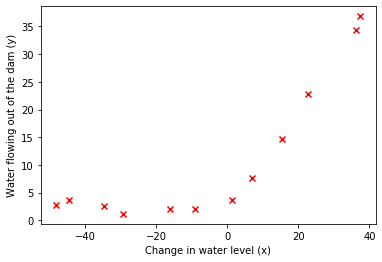

In [3]:
_fig = plt.figure()
ax = _fig.add_subplot(111)
ax.scatter(X, y, c="r", marker="x")
ax.set_xlabel('Change in water level (x)')
ax.set_ylabel('Water flowing out of the dam (y)')


### 1.2 Regularized linear regression cost function

$$
J(\theta) = \frac{1}{2m}\big(\sum^{m}_{i=1}(h_\theta(x^{(i)})-y^{(i)})^{2}\big) + \frac{\lambda}{2m}\big(\sum^{m}_{j=1}\theta_{j}^{2}\big)
$$

### 1.3 Regularized linear regression gradient

$$
\begin{cases}
    \frac{\partial J(\theta)}{\partial\theta_{0}} = \frac{1}{m}\sum_{i=1}^{m}(h_{\theta}(x^{(i)})-y^{(i)})x_{j}^{(i)}& \text{for } j=0\\
    \frac{\partial J(\theta)}{\partial\theta_{j}} = \frac{1}{m}\sum_{i=1}^{m}(h_{\theta}(x^{(i)})-y^{(i)})x_{j}^{(i)} + \frac{\lambda}{m}\theta_{j}& \text{for } j\ge0\\
\end{cases}
$$

In [4]:
def linearRegCostFunction(X, y, theta, _lambda):
    theta = theta.reshape((-1, 1))
    m = y.size
    h = X.dot(theta)
    errs = h - y
    J = (np.sum(np.square(errs)) + _lambda * np.sum(np.square(theta[1:]))) / (m * 2)
    grad = X.T.dot(errs)
    grad[1:] += _lambda * theta[1:]
    return J, (grad / m).flatten()

In [5]:
theta = np.ones((X.shape[1] + 1, 1))
X_with_Ones = np.column_stack((np.ones((y.size, 1)), X))
J, grad = linearRegCostFunction(X_with_Ones, y, theta, 1)

np.testing.assert_approx_equal(J, 303.993192, significant=6)
np.testing.assert_almost_equal(grad, np.array([-15.303016, 598.250744]), decimal=6)

### 1.4 Fitting linear regression

In [6]:
def trainLinearReg(X, y, _lambda, display_msg = True):
    # Initialize Theta
    initial_theta = np.zeros((X.shape[1], 1))

    # Create "short hand" for the cost function to be minimized
    costFunction = lambda x: linearRegCostFunction(X, y, x, _lambda)

    # Minimize using fmincg
    r = minimize(costFunction, initial_theta, method="CG", options={
        'maxiter': 200
    }, jac=True)
    if display_msg:
        display(r)
    return r.x

In [7]:
#  Train linear regression with lambda = 0
theta_result = trainLinearReg(X_with_Ones, y, 0)

     fun: 22.373906495108912
     jac: array([4.95899618e-14, 5.70896866e-14])
 message: 'Optimization terminated successfully.'
    nfev: 5
     nit: 2
    njev: 5
  status: 0
 success: True
       x: array([13.08790351,  0.36777923])

/home/dalao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """Entry point for launching an IPython kernel.


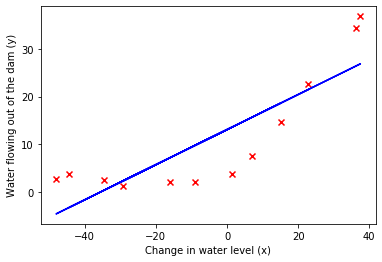

In [8]:
ax = _fig.add_subplot(111)
ax.plot(X, X_with_Ones.dot(theta_result), c="b")
_fig

## 2 Bias-variance

### 2.1 Learning curves

$$
J_{train}(\theta) = \frac{1}{2m}\big[\sum^{m}_{i=1}(h_\theta(x^{(i)})-y^{(i)})^{2}\big]
$$

In [9]:
def learningCurve(X, y, Xval, yval, _lambda):
    m = y.size
    error_train, error_val = np.empty(m), np.empty(m)
    for s in np.arange(m):
        theta = trainLinearReg(X[:s + 1], y[:s + 1], _lambda, display_msg=False)
        # you should compute the error on the training and cross validation set without regularization
        # When you are computing the training set error,
        # make sure you compute it on the training subset
        error_train[s] = linearRegCostFunction(X[:s + 1], y[:s + 1], theta, 0)[0]
        # However, for the cross validation error,
        # you should compute it over the entire cross validation set
        error_val[s] = linearRegCostFunction(Xval, yval, theta, 0)[0]
    return error_train, error_val

you can observe that both the train error and cross validation error are high when the number of training examples is increased. This reflects a high bias problem in the model. THe linear regression model is too simple and is unable to fit our dataset well.

In [10]:
def plotLearningCurve(X, y, Xval, yval, _lambda, ax = None, learningCurve = learningCurve):
    error_train, error_val = learningCurve(X, y, Xval, yval, _lambda)
    if ax is None:
        ax = plt.subplot()
    ax.plot(error_train, label="train")
    ax.plot(error_val, label="Cross validation")
    ax.set_xlabel('Number of training examples')
    ax.set_ylabel('Error')
    ax.set_ylim(0, 100)
    ax.legend()
    ax.set_title(f"lambda={_lambda}")

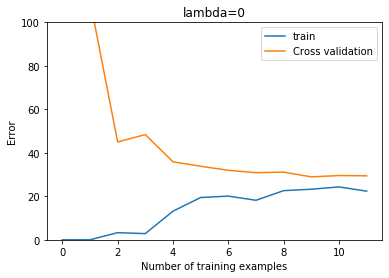

In [11]:
plotLearningCurve(X_with_Ones, y, np.column_stack((np.ones((Xval.shape[0], 1)), Xval)), yval, 0)

## 3 Polynomial regression

In [12]:
def polyFeatures(X, p):
    poly = PolynomialFeatures(degree=8, include_bias=False)
    return poly.fit_transform(X)

### 3.1 Learning Polynomial Regression

In [13]:
def featureNormalize(X, mu = None, sigma = None):
    if mu is None:
        mu = np.mean(X, axis=0)
    if sigma is None:
        sigma = np.std(X, axis=0)
    normalized_X = (X - mu) / sigma
    return normalized_X, mu, sigma

In [14]:
def mapDataset(*args, p):
    # Map X onto Polynomial Features and Normalize
    args = map(lambda dataset: polyFeatures(dataset, p), args)
    # storing the mu, sigma parameters separately
    args = list(args)
    X = args[0]
    mu, sigma = np.mean(X, axis=0), np.std(X, axis=0)
    # normalize (using mu and sigma)
    args = map(lambda dataset: featureNormalize(dataset, mu=mu, sigma=sigma)[0], args)
    # Add Ones
    args = map(lambda dataset: np.column_stack((np.ones((dataset.shape[0], 1)), dataset)), args)
    return list(args)

In [15]:
X_plot = np.linspace(np.min(X), np.max(X)).reshape((-1, 1))

# Map X onto Polynomial Features and Normalize
X_poly, X_poly_test, X_poly_val, X_poly_plot = mapDataset(X, Xtest, Xval, X_plot, p = 8)

In [16]:
def fit_model(_lambda):
    theta = trainLinearReg(X_poly, y, _lambda, display_msg=False)
    ax = _fig.add_subplot(111)
    ax.plot(X_plot, X_poly_plot.dot(theta), label=f"lambda={_lambda}")
    ax.legend()
    display(_fig)
    return theta

/home/dalao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


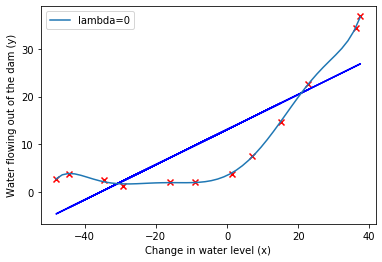

array([ 11.21824777,  10.12758197,  19.67527045,  19.91563596,
       -36.52282765, -51.03103703,  28.34838662,  41.99786529,
         3.59146209])

In [17]:
fit_model(0)

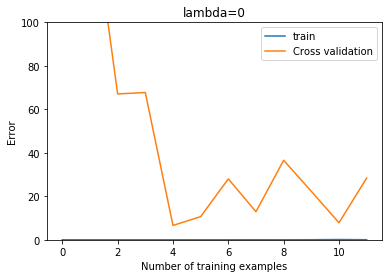

In [18]:
plotLearningCurve(X_poly, y, X_poly_val, yval, 0)

### 3.2 Adjusting the regularization parameter

/home/dalao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


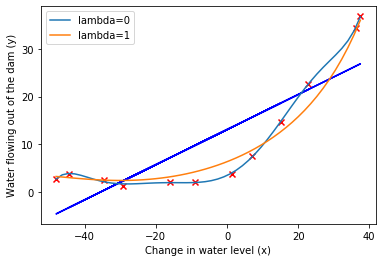

array([11.21759102,  8.36726012,  5.10195863,  3.39010321,  2.15887494,
        1.6204437 ,  0.97249263,  1.02577129,  0.32263362])

In [19]:
fit_model(1)

/home/dalao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


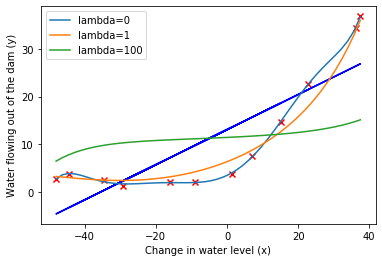

array([11.21758933,  0.99128451,  0.3410157 ,  0.76526037,  0.1568759 ,
        0.56654377,  0.02895654,  0.42467798, -0.05196792])

In [20]:
fit_model(100)

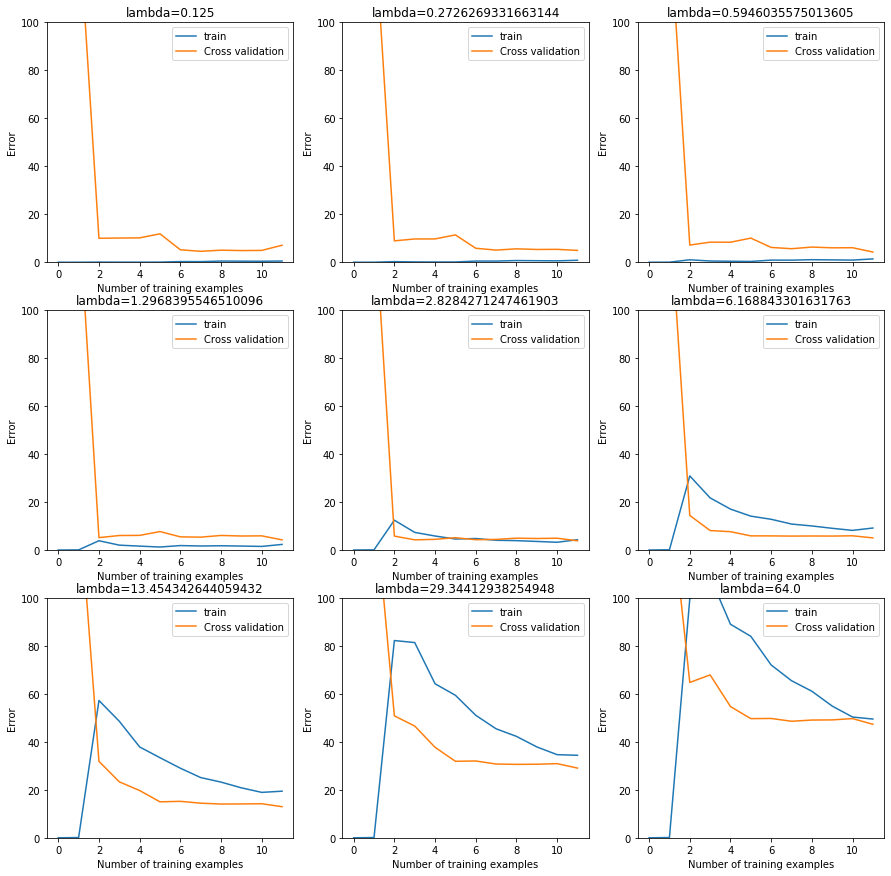

In [21]:
figure, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()
for i, _lambda in enumerate(np.logspace(-3, 6, base=2, num=9)):
    plotLearningCurve(X_poly, y, X_poly_val, yval, _lambda, ax=axes[i])

### 3.3 Selecting lambda using a cross validation set

The value of lambda can significantly affect the results of regularized polunomial regression on the training and cross validation set. In particular, a model without regularization fits the training set well, but does not generalize. Conversely, a model with too much regularization does not fit the training set neither testing well.

In [22]:
def validationCurve(X, y, Xval, yval, nums = 20):
    # lambdas = np.logspace(-3, 2, num=nums)
    lambdas = np.array([0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10])
    error_train, error_val = np.empty(lambdas.size), np.empty(lambdas.size)
    for i in np.arange(lambdas.size):
        theta = trainLinearReg(X, y, lambdas[i], display_msg=False)
        error_train[i] = linearRegCostFunction(X, y, theta, 0)[0]
        error_val[i] = linearRegCostFunction(Xval, yval, theta, 0)[0]
    return lambdas, error_train, error_val

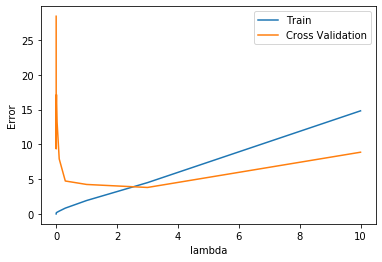

In [23]:
lambda_vec, error_train, error_val = validationCurve(X_poly, y, X_poly_val, yval)
plt.plot(lambda_vec, error_train)
plt.plot(lambda_vec, error_val)
plt.legend(['Train', 'Cross Validation']);
plt.xlabel('lambda');
plt.ylabel('Error');

### 3.4 Computing test set error

/home/dalao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


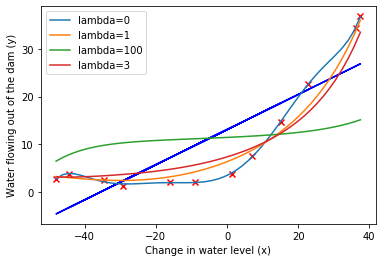

3.8321763825184796
3.5720266195309742


In [24]:
theta = fit_model(3)
print(linearRegCostFunction(X_poly_val, yval, theta, 0)[0])
# To get a better indication of the model's performance in the real world,
# it is important to evaluate the "final" model on 
# a test set that was not used in any part of training
print(linearRegCostFunction(X_poly_test, ytest, theta, 0)[0])

### 3.5 Plotting learning curves with randomly selected examples

In [25]:
def learningCurveRandomlySample(X, y, Xval, yval, _lambda):
    m = y.size
    error_train, error_val = np.empty(m), np.empty(m)
    for s in np.arange(m):
        samples = np.random.choice(m, s + 1, replace=False)
        # randomly select i examples from the training set and
        # i examples from the cross validation set.
        # Learn the parameters theta using the randomly chosen training set
        theta = trainLinearReg(X[samples], y[samples], _lambda, display_msg=False)
        # Evaluate the parameters theta on the randomly chose
        # raining set and cross validation set
        error_train[s] = linearRegCostFunction(X[samples], y[samples], theta, 0)[0]
        error_val[s] = linearRegCostFunction(Xval[samples], yval[samples], theta, 0)[0]
    return error_train, error_val

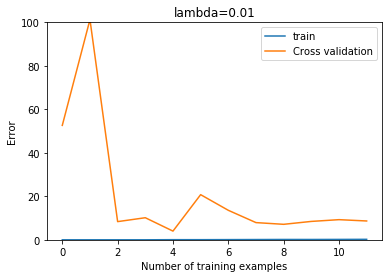

In [26]:
plotLearningCurve(X_poly, y, X_poly_val, yval, 0.01, learningCurve=learningCurveRandomlySample)